# HASV2 - Random forest classifier
Now we will do the same thing, but instead lof logistic regression classifier, we will use random forest classifier

## Description of variables

Inside the `data/hasy-data-labels.csv` file you can find the following variables:

- `path`: The path to the **32x32** images, e.g. hasy-data/v2-00000.png
- `symbol_id`: Symbol id of the image, e.g. character *A* corresponds to symbold id *31*
- `latex`: The latex representation of the symbol, e.g. *\rightarrow*
- `user_id`: Indicates that which symbol belongs to which **user**

# Import the important libraries

Sklearn depends on the scipy and without installation of conda, it is a little bit problematic in the windows OS. One needs to install required libraries **manually**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.utils import shuffle
from PIL import Image, ImageDraw
import scipy.ndimage
from sklearn.ensemble import RandomForestClassifier

# Some library options
pd.options.display.max_rows = 10

c:\users\eozer\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = {'symbols': None, 'images': None}
df = pd.read_csv('../data/HASYv2/hasy-data-labels.csv')
# Filter out the symbol ids
df = df[(df.symbol_id >= 70) & (df.symbol_id <= 80)]

# Assert the # of data points
if len(df) == 1020:
    print('Correct number of data points are selected')
else:
    print('# of data points are not correct, check filter function after read_csv')

df

Correct number of data points are selected


,path,symbol_id,latex,user_id
345,hasy-data/v2-00345.png,70,0,10
346,hasy-data/v2-00346.png,70,0,31
347,hasy-data/v2-00347.png,70,0,10
348,hasy-data/v2-00348.png,70,0,10
349,hasy-data/v2-00349.png,70,0,10
...,...,...,...,...
20823,hasy-data/v2-20823.png,79,9,101356
20824,hasy-data/v2-20824.png,79,9,116471
20825,hasy-data/v2-20825.png,79,9,124511
20826,hasy-data/v2-20826.png,79,9,124916


In [3]:
imgs = np.zeros((len(df), 32*32))

i = 0
for idx, row in df.iterrows():
    path = '../data/HASYv2/' + row['path']
    img = scipy.ndimage.imread(path, flatten=False, mode='L')
    imgs[i, :] = img.flatten()
    i = i + 1

data['symbols'] = df.symbol_id.values
data['images'] = imgs
data['size'] = len(data['symbols'])

data

{'images': array([[ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.]]),
 'size': 1020,
 'symbols': array([70, 70, 70, ..., 79, 79, 79], dtype=int64)}

In [4]:
train_images, test_images, train_symbols, test_symbols = train_test_split(data['images'], data['symbols'], test_size=0.2, train_size=0.8) # This also shuffles by default

# Without tuning the accuracy of the RF classifier

In [5]:
rf = RandomForestClassifier()
rf = rf.fit(train_images, train_symbols) # X y
# Let's check the model's score on the training data
rf.score(train_images, train_symbols)

0.99509803921568629

## Even on the training data itself it is not 100% score, it was in logistic regression

## Lets see accuracy on test data

In [6]:
predict = rf.predict(test_images) # shows the prediction result 
predict_prob = rf.predict_proba(test_images) # shows the prediction probability
# Generate evaluation metrics
acc_logres = metrics.accuracy_score(test_symbols, predict)
print(acc_logres)

0.700980392157


# Accuracy dropped to ~71% _without_ tuning parameters
This is even less than *logistic regression approach*

# Increase # of trees in forest and do the same thing

In [7]:
def rf_classifier(forest_size):
    rf = RandomForestClassifier(n_estimators=forest_size)
    rf = rf.fit(train_images, train_symbols)
    predict = rf.predict(test_images) # shows the prediction result 
    predict_prob = rf.predict_proba(test_images) # shows the prediction probability
    # Generate evaluation metrics
    acc_logres = metrics.accuracy_score(test_symbols, predict)
    return acc_logres

In [8]:
rf_notune_models = []
for i in range(1,21):
    forest_size = i * 10
    accuracy = rf_classifier(forest_size)
    model = {'size': forest_size, 'accuracy': accuracy}
    rf_notune_models.append(model)

# Plot the whole random forests to see their accuracy

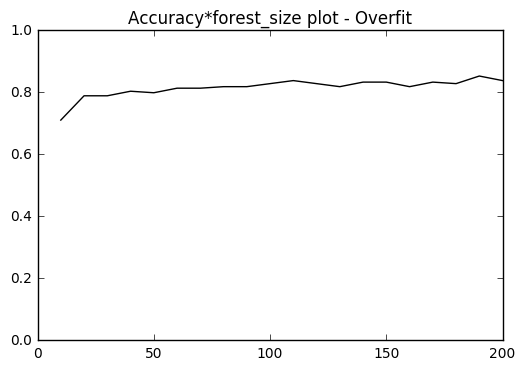

accuracy      0.852941
size        200.000000
dtype: float64


In [9]:
nt_rf = pd.DataFrame.from_dict(rf_notune_models)
plt.plot(nt_rf['size'].values, nt_rf['accuracy'].values, 'k')
plt.axis([0, 200, 0.0, 1.0])
plt.title("Accuracy*forest_size plot - Overfit")
plt.show()

print(nt_rf.max())

# Now reshuffle and make the validation set

In [10]:
def train_test_validation(dX, dY, size_arr=[0.8, 0.2, 0.2]):
    x_train, x_test, y_train, y_test = train_test_split(dX, dY, test_size=size_arr[1])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=size_arr[2])
    return x_train, x_test, x_val, y_train, y_test, y_val

In [11]:
train_images, test_images, val_images, train_symbols, test_symbols, val_symbols = train_test_validation(data['images'], data['symbols'])

In [12]:
def rf_classifier_validation_train(forest_size):
    rf = RandomForestClassifier(n_estimators=forest_size)
    rf = rf.fit(train_images, train_symbols)
    predict = rf.predict(val_images)
    # Generate evaluation metrics
    acc_logres = metrics.accuracy_score(val_symbols, predict)
    return acc_logres

In [13]:
rf_notune_models2 = []
for i in range(1,21):
    forest_size = i * 10
    accuracy = rf_classifier(forest_size)
    model = {'size': forest_size, 'accuracy': accuracy}
    rf_notune_models2.append(model)
rftune = pd.DataFrame.from_dict(rf_notune_models2)
dftune_max = rftune.max()

In [14]:
dftune_max_accsize = int(dftune_max['size'])

# Now test the found size with the test set

In [15]:
rf_classifier(dftune_max_accsize)


0.89215686274509809

# Lets try TPOT module
 TPOT, an automated ML solution that finds a good model and a good set of hyperparameters automatically. 

In [16]:
from tpot import TPOTClassifier

In [17]:
train_images, test_images, train_symbols, test_symbols = train_test_split(data['images'], data['symbols'], test_size=0.2, train_size=0.8) # This also shuffles by default

tpot_c = TPOTClassifier(generations=5, population_size=20, n_jobs=4, config_dict='TPOT light')
tpot_c.fit(train_images, train_symbols)

TPOTClassifier(config_dict={'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.preprocessing.StandardScaler': {}, 'sklearn.tree.DecisionTreeClassifier': {'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 21), 'max_depth': range(1, 1...e_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        generations=5, max_eval_time_mins=5, max_time_mins=None,
        mutation_rate=0.9, n_jobs=4, offspring_size=20, population_size=20,
        random_state=None, scoring=None, subsample=1.0, verbosity=0,
        warm_start=False)

In [18]:
tpot_c.score(test_images, test_symbols)

0.90686274509803921

In [19]:
tpot_c.export('tpot_best_model.py')